In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim 
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import zipfile

In [2]:
def load_data(csv_path, batch_size=32, test_size=0.1, val_size=0.111111, device=torch.device('cpu')):
    """
    加载数据集并划分为训练集、验证集和测试集。
    Args:
        csv_path (str): CSV 文件路径。
        batch_size (int): 批量大小。
        test_size (float): 测试集占总数据的比例。
        val_size (float): 验证集占剩余训练数据的比例。
        device (torch.device): 数据加载的目标设备。
    Returns:
        train_loader, val_loader, test_loader: 数据加载器。
    """
    # 创建ZIP文件对象  
#     with zipfile.ZipFile('./data/public_data.zip', 'r') as zip_ref:  
#     # 获取ZIP文件中的所有文件名  
#         with zip_ref.open('public_data.npy') as file:  
#             # 使用NumPy的load函数读取npy文件内容  
#             data = np.load(file)  
    # 读取CSV文件
    data = pd.read_csv(csv_path)
    print('正在读取数据')
    print(f'数据shape：{data.shape}')
    # 假设输入特征为除最后3列以外的所有列，标签为最后3列
    data = pd.DataFrame(data)
    features = data.iloc[:, :-3].values
    labels = data.iloc[:, -3:].values

    # 对输入特征进行归一化处理
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    # 将最后3列的标签组合成唯一类别索引，用于分层划分
    combined_labels = labels.dot(1 << np.arange(labels.shape[-1]))

    # 分层划分测试集
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    train_val_idx, test_idx = next(stratified_split.split(features, combined_labels))
    X_train_val, X_test = features[train_val_idx], features[test_idx]
    y_train_val, y_test = labels[train_val_idx], labels[test_idx]
    combined_train_val_labels = combined_labels[train_val_idx]

    # 分层划分验证集
    stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=0)
    train_idx, val_idx = next(stratified_split_val.split(X_train_val, combined_train_val_labels))
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    # 转换为PyTorch张量
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    # 创建训练集、验证集和测试集的DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [3]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

    
    
class SpectralGatingNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.complex_weight = nn.Parameter(torch.randn(input_dim, 2, dtype=torch.float32))

    def forward(self, x):
        x = x.to(torch.float32)
        
        x = torch.fft.fft(x, dim=-1, norm='ortho')
        weight = torch.view_as_complex(self.complex_weight)
        x = x * weight
        x = torch.fft.ifft(x, dim=-1, norm='ortho')
        return x

    
class Block(nn.Module):

    def __init__(self, dim, drop=0.2, act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.filter1 = SpectralGatingNetwork(dim)
        self.filter2 = SpectralGatingNetwork(dim)
        self.norm2 = norm_layer(dim)
        self.norm2_1 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=dim, act_layer=act_layer, drop=drop)

    def forward(self, x):

        x1 = self.mlp(self.norm2(self.filter1(self.norm1(x)).real))
        x2 = self.mlp(self.norm2_1(self.filter1(self.norm1(x)).imag))
    
        return x1, x2
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [4]:
class SlidingWindowEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim, window_size, stride):
        """
        使用滑窗对时序数据进行嵌入。
        Args:
            input_dim (int): 每个采样点的输入维度（对于单通道数据为1）。
            embed_dim (int): 线性层输出的特征维度（Transformer的输入维度）。
            window_size (int): 滑窗大小。
            stride (int): 滑窗步长。
        """
        super(SlidingWindowEmbedding, self).__init__()
        self.feq = Block(dim=embed_dim)
        self.feq2 = Block(dim=embed_dim)
#         self.feq3 = Block(dim=embed_dim)
#         self.feq4 = Block(dim=embed_dim)
        self.window_size = window_size
        self.stride = stride
        self.input_dim = input_dim
        self.linear = nn.Linear(input_dim * window_size, embed_dim)
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.linear_com = nn.Linear(4*embed_dim, embed_dim)

    def forward(self, x):
        """
        Args:
            x (Tensor): 输入数据，形状为 [B, T]
        Returns:
            Tensor: 嵌入后的数据，形状为 [B, 滑窗数量, embed_dim]
        """
#         B, T = x.shape  # 批量大小和时序长度

        # 确保输入维度适配线性层
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  # 添加一个通道维度变为 [B, 1, T]
 
        # 提取滑窗，通过 unfold 实现滑窗提取
        x_unfold = F.unfold(x.unsqueeze(1), kernel_size=(self.input_dim, self.window_size), stride=(self.input_dim, self.stride))
        x_unfold = x_unfold.permute(0, 2, 1)  # 转为 [B, 滑窗数量, window_size]
        
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
        # 线性层嵌入映射
        x_embedded = self.linear(x_unfold)
        

        x_real = []
        x_imag = []
        x_real2 = []
        x_imag2 = []
#         x_real3 = []
#         x_imag3 = []
#         x_real4= []
#         x_imag4= []
        for i in range(x_embedded.shape[1]):
            temp1, temp2 = self.feq(x_embedded[:,i,:])
            x_real.append(temp1)
            x_imag.append(temp2)
            
            temp1, temp2 = self.feq2(x_embedded[:,i,:])
            x_real2.append(temp1)
            x_imag2.append(temp2)
            

            
        x_real = torch.stack(x_real, dim=1)
        x_imag = torch.stack(x_imag, dim=1)

        x_real2 = torch.stack(x_real2, dim=1)
        x_imag2 = torch.stack(x_imag2, dim=1)


        x_com = torch.cat((x_real,x_imag, x_real2, x_imag2 ), dim=-1)
        x_com = self.linear_com(x_com)
        
        x_embedded = x_embedded + x_com
        return x_embedded


# 参数定义
batch_size = 32
time_steps = 2050
input_dim = 1  # 单通道时序数据
embed_dim = 256  # 线性层输出维度
window_size = 100
stride = 100

# 创建示例输入
input_data = torch.randn(batch_size, time_steps)  # [B, T]

# 模型实例化
model = SlidingWindowEmbedding(input_dim=input_dim, embed_dim=embed_dim,
                                window_size=window_size, stride=stride)

# 前向传播
output = model(input_data)

print("输入数据形状:", input_data.shape)  # [B, T]
print("嵌入后的数据形状:", output.shape)  # [B, 滑窗数量, embed_dim]

输入数据形状: torch.Size([32, 2050])
嵌入后的数据形状: torch.Size([32, 20, 256])


In [5]:
def micro_false_alarm_rate(y_true, y_pred):
    """
    Computes the micro-averaged False Alarm Rate (NAR) for multi-label classification.

    Args:
        y_true (np.ndarray): Ground truth binary labels, shape (n_samples, n_labels)
        y_pred (np.ndarray): Predicted binary labels, shape (n_samples, n_labels)

    Returns:
        float: Micro-averaged false alarm rate (NAR)
    """
    false_positives = np.logical_and(y_pred == 1, y_true == 0).sum()
    true_negatives_total = (y_true == 0).sum()
    
    if true_negatives_total == 0:
        return 0.0  # Avoid division by zero

    nar = false_positives / true_negatives_total
    return nar

In [6]:
# Transformer 模型
class TransformerMultiLabel(nn.Module):
    def __init__(self, input_dim, embedding_dim, window_size, stride, num_heads, num_classes, nlayer,dropout=0.2): # 特征维度(样本大小)，每个特征的维度，transformer维度
        super(TransformerMultiLabel, self).__init__()
        
        self.time_emb = SlidingWindowEmbedding(input_dim=input_dim, embed_dim=embedding_dim,
                                    window_size=window_size, stride=stride)
        
        self.time_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim , nhead=num_heads, dropout=dropout,batch_first=True),
            num_layers=nlayer
        )  # Transforvmer编码器


        
        self.positional_encoding = PositionalEncoding(embedding_dim)
        self.output_dim = embedding_dim  # Transformer编码器输出的维度
        
        self.output_layers1 = nn.ModuleList([nn.Linear(self.output_dim, self.output_dim) for _ in range(num_classes)])  # 每个事件对应一个输出层
        self.output_layers2 = nn.ModuleList([nn.Linear(self.output_dim, 1) for _ in range(num_classes)])  # 每个事件对应一个输出层

        self.sigmoid = nn.Sigmoid()  # Sigmoid激活函数
                # ====== 参数初始化 ======
        self._init_weights()

    def _init_weights(self):
        """
        初始化权重，确保训练稳定和加速收敛
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Xavier 均匀初始化（适合Sigmoid、Tanh等非ReLU激活）
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0.0)
                nn.init.constant_(m.weight, 1.0)

            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, x):
        """
        :param x: 输入数据，形状为 [B, N]，B为批量大小，N为特征数
        :return: 多标签分类结果，形状为 [B, num_classes]，每个值表示事件发生的概率
        """
        time = self.time_emb(x)
    
        time = self.positional_encoding(time)

        time = self.time_encoder(time)  # 通过Transformer编码器 [B, time_seq, 256]

#         time = time.mean(axis=1)
        
        
        for i in range(len(self.output_layers1)):
            globals()[f'output_{i}'] = []
        
        outputs = []
        Hids = []
        
        for i in range(len(self.output_layers1)):
            
            # nn.BCELoss（二元交叉熵损失）要求目标标签 (labels) 在 [0, 1] 之间。
            #如果标签数据包含超出这个范围的值，将导致损失计算失败，并可能引发CUDA断言错误
            
            hid = self.output_layers1[i](time.mean(axis=1)).squeeze(-1) # [B, time_seq]

            out = self.output_layers2[i](hid).squeeze(-1)  # [B]
            out = self.sigmoid(out)  # 确保输出在 [0, 1]  
            globals()[f'output_{i}'].append(out)
            outputs.append(out) 
            Hids.append(hid)
        outputs = torch.cat((output_0[0].unsqueeze(1), output_1[0].unsqueeze(1), output_2[0].unsqueeze(1)), dim=-1)  

        return outputs,Hids # 拼接所有事件的输出 [B, num_classes]

In [7]:
def train_model(model, scheduler, train_loader, val_loader, criterion, optimizer, num_epochs=20,lambda_mi=0.1, device='cpu'):
    
    train_losses = []
    val_losses = []
    Accuracy = []
    Precision = []
    Recall = []
    Nar = []
    best_val_loss = 0
    best_model_wts = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # 训练阶段
        for features, labels in tqdm(train_loader, desc="Training process"):
            features, labels = features.to(device), labels.to(device)  # 移动到GPU
            optimizer.zero_grad()
            outputs,hid = model(features)
            # outputs = outputs.reshape(-1, 3)
            mi_loss = cosine_similarity_loss(hid)
            loss = criterion(outputs, labels) + lambda_mi * mi_loss   # lambda_mi 是互信息损失的权重
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print('********训练阶段**********')
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

        # 验证阶段
        model.eval()
        val_loss = 0.0
        
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for features, labels in tqdm(val_loader, desc="Validation process"):
                features, labels = features.to(device), labels.to(device)  # 移动到GPU
                outputs, hid= model(features)
                mi_loss = cosine_similarity_loss(hid)
                loss = criterion(outputs, labels) + lambda_mi * mi_loss  
                val_loss += loss.item()

                # 将标签和预测结果保存下来以计算评价指标
                all_labels.append(labels.cpu().numpy())
                all_preds.append((outputs.cpu().numpy() > 0.5).astype(int))  # 使用阈值0.5进行二值化
                # all_preds.append(outputs.cpu().numpy())
#             scheduler.step(val_loss)
                
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        
        
        # 将所有batch的结果拼接在一起
        all_labels = np.vstack(all_labels)
        all_preds = np.vstack(all_preds)
        
#         # 动态调整阈值
#         best_threshold = find_best_thresholds(all_labels, all_preds, 3)
        
#         # 使用最佳阈值进行预测
#         all_preds = (all_preds > best_threshold).astype(int)
#         thresholds.append(best_threshold)

        # 计算准确率、查准率和查全率
        accuracy = accuracy_score(all_labels, all_preds)    # 表示正确预测的样本所占的比例。
        precision = precision_score(all_labels, all_preds, average='micro') # 即在所有预测为正类的样本中，实际为正类的样本比例。
        recall = recall_score(all_labels, all_preds, average='micro') # 即在所有实际为正类的样本中，正确预测为正类的比例。
        nar = micro_false_alarm_rate (all_labels, all_preds)
        Accuracy.append(accuracy)
        Precision.append(precision)
        Recall.append(recall)
        Nar.append(nar)
        print('********验证阶段**********')
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.4f}')
        print(f'Validation Precision: {precision:.4f}')
        print(f'Validation Recall: {recall:.4f}')
        print(f'Nar: {nar:.4f}')
        
        scheduler.step(accuracy)
        # 保存验证集表现最好的模型
        if accuracy > best_val_loss:
            best_val_loss = accuracy
            best_model_wts = model.state_dict()  # 保存最佳模型的参数
            print('最优模型参数更新')
        
    # 保存最优模型
    torch.save(best_model_wts, './best_model/best_model.pth')
    print("Best model saved.")
    return train_losses, val_losses, Accuracy, Precision, Recall, Nar

In [8]:
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion, train_losses, val_losses, Accuracy, Precision, Recall,lambda_mi = 0.1, device='cpu'):
    model.load_state_dict(torch.load('./best_model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)  # 移动到GPU
            outputs, hid = model(features)
            mi_loss = cosine_similarity_loss(hid)
            loss = criterion(outputs, labels)  + lambda_mi * mi_loss         
            # outputs = outputs.reshape(-1, 3)
            loss = criterion(outputs, labels) 
            total_loss += loss.item()

            # 将标签和预测结果保存下来以计算评价指标
            all_labels.append(labels.cpu().numpy())
            all_preds.append((outputs.cpu().numpy() > 0.5).astype(int))  # 使用阈值0.5进行二值化
    
    avg_loss = total_loss / len(test_loader)
    
    # 将所有batch的结果拼接在一起
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    # 计算准确率、查准率和查全率
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')
    nar = micro_false_alarm_rate (all_labels, all_preds)
    
    print('********测试阶段**********')
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Nar: {nar:.4f}')
   
    # 绘制训练损失和验证损失
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.show()

    # 绘制训练损失和验证损失
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, Accuracy, label='Accuracy', )
    plt.plot(epochs, Precision, label='Precision')
    plt.plot(epochs, Recall, label='Recall')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    plt.title('Evaluation Index')
    plt.legend()
    plt.show()
    

    
    return all_labels, all_preds


def cosine_similarity_loss(hid_list):
    """
    计算隐藏层之间的余弦相似度，并返回总的相似度损失。
    :param hid_list: 一个包含多个隐藏层表示的列表 [H1, H2, ..., Hn]，每个的形状为 [B, D]
    :return: 相似度损失标量
    """
    num_hids = len(hid_list)
    loss = 0.0
    for i in range(num_hids):
        for j in range(i + 1, num_hids):
            sim = F.cosine_similarity(hid_list[i], hid_list[j], dim=-1)  # [B]
            loss += sim.mean()  # 平均相似度
    return abs(loss)  # 归一化到成对的平均相似度


# def cosine_similarity_loss(hid_list):
#     """
#     计算隐藏层之间的欧几里得距离，并返回总的距离损失。
#     :param hid_list: 一个包含多个隐藏层表示的列表 [H1, H2, ..., Hn]，每个的形状为 [B, D]
#     :return: 距离损失标量
#     """
#     num_hids = len(hid_list)
#     loss = 0.0
#     for i in range(num_hids):
#         for j in range(i + 1, num_hids):
#             dist = torch.norm(hid_list[i] - hid_list[j], p=2, dim=-1)  # [B] 计算 L2 范数
#             loss += dist.mean()  # 计算平均欧几里得距离
#     return -torch.log(loss/20)


cosine_similarity_loss(torch.randn(3,32,20))

tensor(0.1213)

Using device: cuda
正在读取数据
数据shape：(8200, 2053)


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:51<00:00,  4.04it/s]


********训练阶段**********
Epoch [1/200], Train Loss: 0.7171


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 15.49it/s]


********验证阶段**********
Epoch [1/200], Validation Loss: 0.7352
Validation Accuracy: 0.0086
Validation Precision: 0.4821
Validation Recall: 0.0207
Nar: 0.0257
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:46<00:00,  4.42it/s]


********训练阶段**********
Epoch [2/200], Train Loss: 0.7061


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.95it/s]


********验证阶段**********
Epoch [2/200], Validation Loss: 0.7035
Validation Accuracy: 0.1330
Validation Precision: 0.5305
Validation Recall: 0.4858
Nar: 0.4978
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:47<00:00,  4.36it/s]


********训练阶段**********
Epoch [3/200], Train Loss: 0.7002


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.76it/s]


********验证阶段**********
Epoch [3/200], Validation Loss: 0.6790
Validation Accuracy: 0.1749
Validation Precision: 0.5591
Validation Recall: 0.8508
Nar: 0.7768
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:47<00:00,  4.38it/s]


********训练阶段**********
Epoch [4/200], Train Loss: 0.6785


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 15.89it/s]


********验证阶段**********
Epoch [4/200], Validation Loss: 0.6610
Validation Accuracy: 0.1256
Validation Precision: 0.6940
Validation Recall: 0.2846
Nar: 0.1453


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.22it/s]


********训练阶段**********
Epoch [5/200], Train Loss: 0.6462


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 15.39it/s]


********验证阶段**********
Epoch [5/200], Validation Loss: 0.6171
Validation Accuracy: 0.3116
Validation Precision: 0.6562
Validation Recall: 0.6526
Nar: 0.3959
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.26it/s]


********训练阶段**********
Epoch [6/200], Train Loss: 0.6222


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.52it/s]


********验证阶段**********
Epoch [6/200], Validation Loss: 0.5904
Validation Accuracy: 0.3190
Validation Precision: 0.6461
Validation Recall: 0.7529
Nar: 0.4774
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:47<00:00,  4.30it/s]


********训练阶段**********
Epoch [7/200], Train Loss: 0.6004


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.00it/s]


********验证阶段**********
Epoch [7/200], Validation Loss: 0.5941
Validation Accuracy: 0.3658
Validation Precision: 0.7178
Validation Recall: 0.6052
Nar: 0.2755
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:45<00:00,  4.52it/s]


********训练阶段**********
Epoch [8/200], Train Loss: 0.5864


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 16.20it/s]


********验证阶段**********
Epoch [8/200], Validation Loss: 0.5616
Validation Accuracy: 0.3805
Validation Precision: 0.7664
Validation Recall: 0.5998
Nar: 0.2117
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:38<00:00,  5.40it/s]


********训练阶段**********
Epoch [9/200], Train Loss: 0.5770


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 15.73it/s]


********验证阶段**********
Epoch [9/200], Validation Loss: 0.5625
Validation Accuracy: 0.4039
Validation Precision: 0.7581
Validation Recall: 0.6450
Nar: 0.2383
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.22it/s]


********训练阶段**********
Epoch [10/200], Train Loss: 0.5571


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.38it/s]


********验证阶段**********
Epoch [10/200], Validation Loss: 0.5481
Validation Accuracy: 0.3510
Validation Precision: 0.6705
Validation Recall: 0.7957
Nar: 0.4526


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.14it/s]


********训练阶段**********
Epoch [11/200], Train Loss: 0.5488


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.58it/s]


********验证阶段**********
Epoch [11/200], Validation Loss: 0.5237
Validation Accuracy: 0.4409
Validation Precision: 0.7952
Validation Recall: 0.6595
Nar: 0.1966
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:47<00:00,  4.32it/s]


********训练阶段**********
Epoch [12/200], Train Loss: 0.5347


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 15.53it/s]


********验证阶段**********
Epoch [12/200], Validation Loss: 0.5134
Validation Accuracy: 0.4372
Validation Precision: 0.8020
Validation Recall: 0.6664
Nar: 0.1904


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.17it/s]


********训练阶段**********
Epoch [13/200], Train Loss: 0.5153


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.08it/s]


********验证阶段**********
Epoch [13/200], Validation Loss: 0.5172
Validation Accuracy: 0.4409
Validation Precision: 0.7994
Validation Recall: 0.6618
Nar: 0.1922


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.17it/s]


********训练阶段**********
Epoch [14/200], Train Loss: 0.5002


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.08it/s]


********验证阶段**********
Epoch [14/200], Validation Loss: 0.5007
Validation Accuracy: 0.4212
Validation Precision: 0.7404
Validation Recall: 0.7988
Nar: 0.3242


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:50<00:00,  4.11it/s]


********训练阶段**********
Epoch [15/200], Train Loss: 0.4902


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.26it/s]


********验证阶段**********
Epoch [15/200], Validation Loss: 0.4685
Validation Accuracy: 0.4520
Validation Precision: 0.7836
Validation Recall: 0.7368
Nar: 0.2356
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.17it/s]


********训练阶段**********
Epoch [16/200], Train Loss: 0.4753


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.98it/s]


********验证阶段**********
Epoch [16/200], Validation Loss: 0.4761
Validation Accuracy: 0.4766
Validation Precision: 0.8326
Validation Recall: 0.7001
Nar: 0.1630
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.19it/s]


********训练阶段**********
Epoch [17/200], Train Loss: 0.4619


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.62it/s]


********验证阶段**********
Epoch [17/200], Validation Loss: 0.4406
Validation Accuracy: 0.4692
Validation Precision: 0.7792
Validation Recall: 0.8072
Nar: 0.2648


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:47<00:00,  4.31it/s]


********训练阶段**********
Epoch [18/200], Train Loss: 0.4482


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 12.17it/s]


********验证阶段**********
Epoch [18/200], Validation Loss: 0.4596
Validation Accuracy: 0.5012
Validation Precision: 0.8343
Validation Recall: 0.7399
Nar: 0.1701
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.13it/s]


********训练阶段**********
Epoch [19/200], Train Loss: 0.4452


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.30it/s]


********验证阶段**********
Epoch [19/200], Validation Loss: 0.4324
Validation Accuracy: 0.5000
Validation Precision: 0.8286
Validation Recall: 0.7582
Nar: 0.1816


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.17it/s]


********训练阶段**********
Epoch [20/200], Train Loss: 0.4250


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.84it/s]


********验证阶段**********
Epoch [20/200], Validation Loss: 0.4646
Validation Accuracy: 0.5062
Validation Precision: 0.8354
Validation Recall: 0.7108
Nar: 0.1621
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:47<00:00,  4.30it/s]


********训练阶段**********
Epoch [21/200], Train Loss: 0.4258


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.43it/s]


********验证阶段**********
Epoch [21/200], Validation Loss: 0.4130
Validation Accuracy: 0.5246
Validation Precision: 0.8454
Validation Recall: 0.7697
Nar: 0.1630
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.25it/s]


********训练阶段**********
Epoch [22/200], Train Loss: 0.4089


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.66it/s]


********验证阶段**********
Epoch [22/200], Validation Loss: 0.4376
Validation Accuracy: 0.5542
Validation Precision: 0.8471
Validation Recall: 0.7460
Nar: 0.1559
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:50<00:00,  4.07it/s]


********训练阶段**********
Epoch [23/200], Train Loss: 0.4033


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 12.87it/s]


********验证阶段**********
Epoch [23/200], Validation Loss: 0.3999
Validation Accuracy: 0.5468
Validation Precision: 0.8428
Validation Recall: 0.7835
Nar: 0.1692


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.27it/s]


********训练阶段**********
Epoch [24/200], Train Loss: 0.3922


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.66it/s]


********验证阶段**********
Epoch [24/200], Validation Loss: 0.3932
Validation Accuracy: 0.5800
Validation Precision: 0.8718
Validation Recall: 0.7598
Nar: 0.1293
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.24it/s]


********训练阶段**********
Epoch [25/200], Train Loss: 0.3867


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.78it/s]


********验证阶段**********
Epoch [25/200], Validation Loss: 0.4324
Validation Accuracy: 0.5111
Validation Precision: 0.8325
Validation Recall: 0.7605
Nar: 0.1771


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.16it/s]


********训练阶段**********
Epoch [26/200], Train Loss: 0.3859


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.67it/s]


********验证阶段**********
Epoch [26/200], Validation Loss: 0.3879
Validation Accuracy: 0.5653
Validation Precision: 0.8515
Validation Recall: 0.8072
Nar: 0.1630


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.18it/s]


********训练阶段**********
Epoch [27/200], Train Loss: 0.3813


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.15it/s]


********验证阶段**********
Epoch [27/200], Validation Loss: 0.3624
Validation Accuracy: 0.5899
Validation Precision: 0.8547
Validation Recall: 0.8279
Nar: 0.1630
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:50<00:00,  4.10it/s]


********训练阶段**********
Epoch [28/200], Train Loss: 0.3615


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.57it/s]


********验证阶段**********
Epoch [28/200], Validation Loss: 0.3470
Validation Accuracy: 0.6268
Validation Precision: 0.8755
Validation Recall: 0.8233
Nar: 0.1355
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:50<00:00,  4.07it/s]


********训练阶段**********
Epoch [29/200], Train Loss: 0.3579


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 12.61it/s]


********验证阶段**********
Epoch [29/200], Validation Loss: 0.3702
Validation Accuracy: 0.6330
Validation Precision: 0.8645
Validation Recall: 0.8057
Nar: 0.1461
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.18it/s]


********训练阶段**********
Epoch [30/200], Train Loss: 0.3497


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 12.63it/s]


********验证阶段**********
Epoch [30/200], Validation Loss: 0.3486
Validation Accuracy: 0.6281
Validation Precision: 0.8831
Validation Recall: 0.8095
Nar: 0.1240


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.18it/s]


********训练阶段**********
Epoch [31/200], Train Loss: 0.3551


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 12.76it/s]


********验证阶段**********
Epoch [31/200], Validation Loss: 0.3330
Validation Accuracy: 0.6318
Validation Precision: 0.8775
Validation Recall: 0.8386
Nar: 0.1355


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:50<00:00,  4.09it/s]


********训练阶段**********
Epoch [32/200], Train Loss: 0.3378


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.65it/s]


********验证阶段**********
Epoch [32/200], Validation Loss: 0.3391
Validation Accuracy: 0.6355
Validation Precision: 0.8815
Validation Recall: 0.8363
Nar: 0.1302
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.25it/s]


********训练阶段**********
Epoch [33/200], Train Loss: 0.3350


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.35it/s]


********验证阶段**********
Epoch [33/200], Validation Loss: 0.3437
Validation Accuracy: 0.6539
Validation Precision: 0.9043
Validation Recall: 0.8095
Nar: 0.0992
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:50<00:00,  4.04it/s]


********训练阶段**********
Epoch [34/200], Train Loss: 0.3305


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.62it/s]


********验证阶段**********
Epoch [34/200], Validation Loss: 0.3132
Validation Accuracy: 0.6527
Validation Precision: 0.8672
Validation Recall: 0.8592
Nar: 0.1523


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.23it/s]


********训练阶段**********
Epoch [35/200], Train Loss: 0.3147


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.40it/s]


********验证阶段**********
Epoch [35/200], Validation Loss: 0.2989
Validation Accuracy: 0.6749
Validation Precision: 0.9007
Validation Recall: 0.8470
Nar: 0.1081
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:47<00:00,  4.29it/s]


********训练阶段**********
Epoch [36/200], Train Loss: 0.3145


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 12.74it/s]


********验证阶段**********
Epoch [36/200], Validation Loss: 0.3077
Validation Accuracy: 0.6663
Validation Precision: 0.8798
Validation Recall: 0.8623
Nar: 0.1364


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.24it/s]


********训练阶段**********
Epoch [37/200], Train Loss: 0.3049


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 12.38it/s]


********验证阶段**********
Epoch [37/200], Validation Loss: 0.2975
Validation Accuracy: 0.6773
Validation Precision: 0.9071
Validation Recall: 0.8370
Nar: 0.0992
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:47<00:00,  4.31it/s]


********训练阶段**********
Epoch [38/200], Train Loss: 0.3007


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.32it/s]


********验证阶段**********
Epoch [38/200], Validation Loss: 0.3283
Validation Accuracy: 0.6675
Validation Precision: 0.8430
Validation Recall: 0.8998
Nar: 0.1940


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:47<00:00,  4.29it/s]


********训练阶段**********
Epoch [39/200], Train Loss: 0.2945


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.10it/s]


********验证阶段**********
Epoch [39/200], Validation Loss: 0.2863
Validation Accuracy: 0.6958
Validation Precision: 0.8947
Validation Recall: 0.8707
Nar: 0.1187
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.24it/s]


********训练阶段**********
Epoch [40/200], Train Loss: 0.2843


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.13it/s]


********验证阶段**********
Epoch [40/200], Validation Loss: 0.2784
Validation Accuracy: 0.6946
Validation Precision: 0.9221
Validation Recall: 0.8424
Nar: 0.0824


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.22it/s]


********训练阶段**********
Epoch [41/200], Train Loss: 0.2886


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.41it/s]


********验证阶段**********
Epoch [41/200], Validation Loss: 0.2630
Validation Accuracy: 0.6921
Validation Precision: 0.8953
Validation Recall: 0.8768
Nar: 0.1187


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.22it/s]


********训练阶段**********
Epoch [42/200], Train Loss: 0.2797


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.66it/s]


********验证阶段**********
Epoch [42/200], Validation Loss: 0.2962
Validation Accuracy: 0.6576
Validation Precision: 0.8939
Validation Recall: 0.8447
Nar: 0.1160


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:49<00:00,  4.17it/s]


********训练阶段**********
Epoch [43/200], Train Loss: 0.2676


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.89it/s]


********验证阶段**********
Epoch [43/200], Validation Loss: 0.2658
Validation Accuracy: 0.6995
Validation Precision: 0.8919
Validation Recall: 0.8898
Nar: 0.1249
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:48<00:00,  4.21it/s]


********训练阶段**********
Epoch [44/200], Train Loss: 0.2648


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.80it/s]


********验证阶段**********
Epoch [44/200], Validation Loss: 0.3380
Validation Accuracy: 0.6909
Validation Precision: 0.8856
Validation Recall: 0.8768
Nar: 0.1311


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:45<00:00,  4.54it/s]


********训练阶段**********
Epoch [45/200], Train Loss: 0.2667


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 15.88it/s]


********验证阶段**********
Epoch [45/200], Validation Loss: 0.2672
Validation Accuracy: 0.7217
Validation Precision: 0.8980
Validation Recall: 0.8822
Nar: 0.1160
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:39<00:00,  5.20it/s]


********训练阶段**********
Epoch [46/200], Train Loss: 0.2620


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.76it/s]


********验证阶段**********
Epoch [46/200], Validation Loss: 0.2652
Validation Accuracy: 0.7241
Validation Precision: 0.9273
Validation Recall: 0.8684
Nar: 0.0788
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.46it/s]


********训练阶段**********
Epoch [47/200], Train Loss: 0.2468


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 19.67it/s]


********验证阶段**********
Epoch [47/200], Validation Loss: 0.2382
Validation Accuracy: 0.7438
Validation Precision: 0.9175
Validation Recall: 0.8936
Nar: 0.0930
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:33<00:00,  6.21it/s]


********训练阶段**********
Epoch [48/200], Train Loss: 0.2452


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 18.23it/s]


********验证阶段**********
Epoch [48/200], Validation Loss: 0.2384
Validation Accuracy: 0.7438
Validation Precision: 0.9135
Validation Recall: 0.8891
Nar: 0.0974


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:32<00:00,  6.43it/s]


********训练阶段**********
Epoch [49/200], Train Loss: 0.2455


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.05it/s]


********验证阶段**********
Epoch [49/200], Validation Loss: 0.2441
Validation Accuracy: 0.7266
Validation Precision: 0.9095
Validation Recall: 0.8768
Nar: 0.1010


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:34<00:00,  5.96it/s]


********训练阶段**********
Epoch [50/200], Train Loss: 0.2421


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 19.69it/s]


********验证阶段**********
Epoch [50/200], Validation Loss: 0.2320
Validation Accuracy: 0.7599
Validation Precision: 0.9180
Validation Recall: 0.8990
Nar: 0.0930
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.94it/s]


********训练阶段**********
Epoch [51/200], Train Loss: 0.2379


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.00it/s]


********验证阶段**********
Epoch [51/200], Validation Loss: 0.2314
Validation Accuracy: 0.7599
Validation Precision: 0.9080
Validation Recall: 0.9135
Nar: 0.1072


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.89it/s]


********训练阶段**********
Epoch [52/200], Train Loss: 0.2337


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 19.25it/s]


********验证阶段**********
Epoch [52/200], Validation Loss: 0.2244
Validation Accuracy: 0.7709
Validation Precision: 0.9355
Validation Recall: 0.8982
Nar: 0.0717
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.64it/s]


********训练阶段**********
Epoch [53/200], Train Loss: 0.2245


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.92it/s]


********验证阶段**********
Epoch [53/200], Validation Loss: 0.2176
Validation Accuracy: 0.7648
Validation Precision: 0.9197
Validation Recall: 0.9112
Nar: 0.0921


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:32<00:00,  6.39it/s]


********训练阶段**********
Epoch [54/200], Train Loss: 0.2240


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 17.81it/s]


********验证阶段**********
Epoch [54/200], Validation Loss: 0.2171
Validation Accuracy: 0.7586
Validation Precision: 0.9094
Validation Recall: 0.9143
Nar: 0.1054


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.81it/s]


********训练阶段**********
Epoch [55/200], Train Loss: 0.2237


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.77it/s]


********验证阶段**********
Epoch [55/200], Validation Loss: 0.2211
Validation Accuracy: 0.7709
Validation Precision: 0.9273
Validation Recall: 0.8975
Nar: 0.0815


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.62it/s]


********训练阶段**********
Epoch [56/200], Train Loss: 0.2173


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.68it/s]


********验证阶段**********
Epoch [56/200], Validation Loss: 0.2186
Validation Accuracy: 0.7808
Validation Precision: 0.9205
Validation Recall: 0.9128
Nar: 0.0912
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.97it/s]


********训练阶段**********
Epoch [57/200], Train Loss: 0.2132


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.14it/s]


********验证阶段**********
Epoch [57/200], Validation Loss: 0.2610
Validation Accuracy: 0.7672
Validation Precision: 0.9109
Validation Recall: 0.8914
Nar: 0.1010


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.61it/s]


********训练阶段**********
Epoch [58/200], Train Loss: 0.2107


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.76it/s]


********验证阶段**********
Epoch [58/200], Validation Loss: 0.2288
Validation Accuracy: 0.7734
Validation Precision: 0.9335
Validation Recall: 0.8921
Nar: 0.0735


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:32<00:00,  6.42it/s]


********训练阶段**********
Epoch [59/200], Train Loss: 0.2033


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 27.81it/s]


********验证阶段**********
Epoch [59/200], Validation Loss: 0.2319
Validation Accuracy: 0.7685
Validation Precision: 0.9194
Validation Recall: 0.9082
Nar: 0.0921


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.87it/s]


********训练阶段**********
Epoch [60/200], Train Loss: 0.2067


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.03it/s]


********验证阶段**********
Epoch [60/200], Validation Loss: 0.1869
Validation Accuracy: 0.7857
Validation Precision: 0.9317
Validation Recall: 0.9181
Nar: 0.0779
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.58it/s]


********训练阶段**********
Epoch [61/200], Train Loss: 0.2051


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.83it/s]


********验证阶段**********
Epoch [61/200], Validation Loss: 0.2046
Validation Accuracy: 0.7833
Validation Precision: 0.9609
Validation Recall: 0.8837
Nar: 0.0416


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:38<00:00,  5.34it/s]


********训练阶段**********
Epoch [62/200], Train Loss: 0.1988


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 18.81it/s]


********验证阶段**********
Epoch [62/200], Validation Loss: 0.1917
Validation Accuracy: 0.8128
Validation Precision: 0.9284
Validation Recall: 0.9327
Nar: 0.0833
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:33<00:00,  6.09it/s]


********训练阶段**********
Epoch [63/200], Train Loss: 0.1872


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 19.28it/s]


********验证阶段**********
Epoch [63/200], Validation Loss: 0.2302
Validation Accuracy: 0.7759
Validation Precision: 0.9022
Validation Recall: 0.9319
Nar: 0.1169


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.72it/s]


********训练阶段**********
Epoch [64/200], Train Loss: 0.1907


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 30.06it/s]


********验证阶段**********
Epoch [64/200], Validation Loss: 0.2481
Validation Accuracy: 0.7574
Validation Precision: 0.8956
Validation Recall: 0.9250
Nar: 0.1249


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.64it/s]


********训练阶段**********
Epoch [65/200], Train Loss: 0.1983


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.80it/s]


********验证阶段**********
Epoch [65/200], Validation Loss: 0.2050
Validation Accuracy: 0.7734
Validation Precision: 0.9154
Validation Recall: 0.9189
Nar: 0.0983


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.59it/s]


********训练阶段**********
Epoch [66/200], Train Loss: 0.1863


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.56it/s]


********验证阶段**********
Epoch [66/200], Validation Loss: 0.1983
Validation Accuracy: 0.7783
Validation Precision: 0.9078
Validation Recall: 0.9342
Nar: 0.1098


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:32<00:00,  6.43it/s]


********训练阶段**********
Epoch [67/200], Train Loss: 0.1859


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.11it/s]


********验证阶段**********
Epoch [67/200], Validation Loss: 0.1770
Validation Accuracy: 0.7968
Validation Precision: 0.9210
Validation Recall: 0.9365
Nar: 0.0930


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.70it/s]


********训练阶段**********
Epoch [68/200], Train Loss: 0.1819


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.05it/s]


********验证阶段**********
Epoch [68/200], Validation Loss: 0.1851
Validation Accuracy: 0.7968
Validation Precision: 0.9353
Validation Recall: 0.9181
Nar: 0.0735


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.80it/s]


********训练阶段**********
Epoch [69/200], Train Loss: 0.1745


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.59it/s]


********验证阶段**********
Epoch [69/200], Validation Loss: 0.1848
Validation Accuracy: 0.7980
Validation Precision: 0.9230
Validation Recall: 0.9258
Nar: 0.0895


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.99it/s]


********训练阶段**********
Epoch [70/200], Train Loss: 0.1787


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.22it/s]


********验证阶段**********
Epoch [70/200], Validation Loss: 0.1882
Validation Accuracy: 0.7980
Validation Precision: 0.9360
Validation Recall: 0.9174
Nar: 0.0726


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.44it/s]


********训练阶段**********
Epoch [71/200], Train Loss: 0.1774


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.55it/s]


********验证阶段**********
Epoch [71/200], Validation Loss: 0.1898
Validation Accuracy: 0.8103
Validation Precision: 0.9362
Validation Recall: 0.9212
Nar: 0.0726


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.64it/s]


********训练阶段**********
Epoch [72/200], Train Loss: 0.1790


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 19.35it/s]


********验证阶段**********
Epoch [72/200], Validation Loss: 0.1809
Validation Accuracy: 0.8177
Validation Precision: 0.9531
Validation Recall: 0.9174
Nar: 0.0523
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.52it/s]


********训练阶段**********
Epoch [73/200], Train Loss: 0.1794


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 18.45it/s]


********验证阶段**********
Epoch [73/200], Validation Loss: 0.1843
Validation Accuracy: 0.8177
Validation Precision: 0.9427
Validation Recall: 0.9181
Nar: 0.0647


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.88it/s]


********训练阶段**********
Epoch [74/200], Train Loss: 0.1620


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.62it/s]


********验证阶段**********
Epoch [74/200], Validation Loss: 0.1785
Validation Accuracy: 0.8165
Validation Precision: 0.9493
Validation Recall: 0.9174
Nar: 0.0567


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.59it/s]


********训练阶段**********
Epoch [75/200], Train Loss: 0.1651


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.86it/s]


********验证阶段**********
Epoch [75/200], Validation Loss: 0.1734
Validation Accuracy: 0.8116
Validation Precision: 0.9177
Validation Recall: 0.9472
Nar: 0.0983


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:27<00:00,  7.46it/s]


********训练阶段**********
Epoch [76/200], Train Loss: 0.1574


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.73it/s]


********验证阶段**********
Epoch [76/200], Validation Loss: 0.1672
Validation Accuracy: 0.8276
Validation Precision: 0.9354
Validation Recall: 0.9411
Nar: 0.0753
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.14it/s]


********训练阶段**********
Epoch [77/200], Train Loss: 0.1606


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.10it/s]


********验证阶段**********
Epoch [77/200], Validation Loss: 0.1686
Validation Accuracy: 0.8165
Validation Precision: 0.9313
Validation Recall: 0.9334
Nar: 0.0797


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.08it/s]


********训练阶段**********
Epoch [78/200], Train Loss: 0.1579


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 19.96it/s]


********验证阶段**********
Epoch [78/200], Validation Loss: 0.1722
Validation Accuracy: 0.8128
Validation Precision: 0.9520
Validation Recall: 0.9112
Nar: 0.0531


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.35it/s]


********训练阶段**********
Epoch [79/200], Train Loss: 0.1607


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.03it/s]


********验证阶段**********
Epoch [79/200], Validation Loss: 0.1712
Validation Accuracy: 0.8239
Validation Precision: 0.9420
Validation Recall: 0.9311
Nar: 0.0664


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.12it/s]


********训练阶段**********
Epoch [80/200], Train Loss: 0.1569


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.55it/s]


********验证阶段**********
Epoch [80/200], Validation Loss: 0.1862
Validation Accuracy: 0.8177
Validation Precision: 0.9203
Validation Recall: 0.9457
Nar: 0.0948


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.11it/s]


********训练阶段**********
Epoch [81/200], Train Loss: 0.1511


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.01it/s]


********验证阶段**********
Epoch [81/200], Validation Loss: 0.1729
Validation Accuracy: 0.8165
Validation Precision: 0.9190
Validation Recall: 0.9549
Nar: 0.0974


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.34it/s]


********训练阶段**********
Epoch [82/200], Train Loss: 0.1553


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.80it/s]


********验证阶段**********
Epoch [82/200], Validation Loss: 0.1640
Validation Accuracy: 0.8276
Validation Precision: 0.9511
Validation Recall: 0.9235
Nar: 0.0549


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.87it/s]


********训练阶段**********
Epoch [83/200], Train Loss: 0.1512


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.59it/s]


********验证阶段**********
Epoch [83/200], Validation Loss: 0.2065
Validation Accuracy: 0.8202
Validation Precision: 0.9391
Validation Recall: 0.9197
Nar: 0.0691


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:32<00:00,  6.32it/s]


********训练阶段**********
Epoch [84/200], Train Loss: 0.1604


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.01it/s]


********验证阶段**********
Epoch [84/200], Validation Loss: 0.1551
Validation Accuracy: 0.8374
Validation Precision: 0.9398
Validation Recall: 0.9441
Nar: 0.0700
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.00it/s]


********训练阶段**********
Epoch [85/200], Train Loss: 0.1477


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.55it/s]


********验证阶段**********
Epoch [85/200], Validation Loss: 0.1739
Validation Accuracy: 0.8387
Validation Precision: 0.9481
Validation Recall: 0.9365
Nar: 0.0593
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.31it/s]


********训练阶段**********
Epoch [86/200], Train Loss: 0.1420


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.01it/s]


********验证阶段**********
Epoch [86/200], Validation Loss: 0.1756
Validation Accuracy: 0.8251
Validation Precision: 0.9363
Validation Recall: 0.9342
Nar: 0.0735


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.11it/s]


********训练阶段**********
Epoch [87/200], Train Loss: 0.1477


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.40it/s]


********验证阶段**********
Epoch [87/200], Validation Loss: 0.1504
Validation Accuracy: 0.8522
Validation Precision: 0.9375
Validation Recall: 0.9533
Nar: 0.0735
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.15it/s]


********训练阶段**********
Epoch [88/200], Train Loss: 0.1402


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.44it/s]


********验证阶段**********
Epoch [88/200], Validation Loss: 0.1621
Validation Accuracy: 0.8264
Validation Precision: 0.9313
Validation Recall: 0.9441
Nar: 0.0806


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.96it/s]


********训练阶段**********
Epoch [89/200], Train Loss: 0.1429


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.98it/s]


********验证阶段**********
Epoch [89/200], Validation Loss: 0.1804
Validation Accuracy: 0.8054
Validation Precision: 0.9242
Validation Recall: 0.9334
Nar: 0.0886


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:27<00:00,  7.59it/s]


********训练阶段**********
Epoch [90/200], Train Loss: 0.1422


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.31it/s]


********验证阶段**********
Epoch [90/200], Validation Loss: 0.1510
Validation Accuracy: 0.8337
Validation Precision: 0.9273
Validation Recall: 0.9564
Nar: 0.0868


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.82it/s]


********训练阶段**********
Epoch [91/200], Train Loss: 0.1359


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.18it/s]


********验证阶段**********
Epoch [91/200], Validation Loss: 0.1881
Validation Accuracy: 0.8559
Validation Precision: 0.9419
Validation Recall: 0.9419
Nar: 0.0673
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.67it/s]


********训练阶段**********
Epoch [92/200], Train Loss: 0.1284


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.36it/s]


********验证阶段**********
Epoch [92/200], Validation Loss: 0.1637
Validation Accuracy: 0.8448
Validation Precision: 0.9693
Validation Recall: 0.9181
Nar: 0.0337


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.13it/s]


********训练阶段**********
Epoch [93/200], Train Loss: 0.1376


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.37it/s]


********验证阶段**********
Epoch [93/200], Validation Loss: 0.1710
Validation Accuracy: 0.8054
Validation Precision: 0.9193
Validation Recall: 0.9495
Nar: 0.0965


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:27<00:00,  7.44it/s]


********训练阶段**********
Epoch [94/200], Train Loss: 0.1355


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.52it/s]


********验证阶段**********
Epoch [94/200], Validation Loss: 0.1594
Validation Accuracy: 0.8239
Validation Precision: 0.9214
Validation Recall: 0.9602
Nar: 0.0948


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.19it/s]


********训练阶段**********
Epoch [95/200], Train Loss: 0.1377


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.41it/s]


********验证阶段**********
Epoch [95/200], Validation Loss: 0.1356
Validation Accuracy: 0.8707
Validation Precision: 0.9562
Validation Recall: 0.9510
Nar: 0.0505
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.23it/s]


********训练阶段**********
Epoch [96/200], Train Loss: 0.1406


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 27.53it/s]


********验证阶段**********
Epoch [96/200], Validation Loss: 0.1442
Validation Accuracy: 0.8436
Validation Precision: 0.9497
Validation Recall: 0.9388
Nar: 0.0576


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.25it/s]


********训练阶段**********
Epoch [97/200], Train Loss: 0.1320


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.38it/s]


********验证阶段**********
Epoch [97/200], Validation Loss: 0.1775
Validation Accuracy: 0.7968
Validation Precision: 0.9116
Validation Recall: 0.9464
Nar: 0.1063


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.16it/s]


********训练阶段**********
Epoch [98/200], Train Loss: 0.1304


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.71it/s]


********验证阶段**********
Epoch [98/200], Validation Loss: 0.1511
Validation Accuracy: 0.8571
Validation Precision: 0.9571
Validation Recall: 0.9388
Nar: 0.0487


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.16it/s]


********训练阶段**********
Epoch [99/200], Train Loss: 0.1243


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.05it/s]


********验证阶段**********
Epoch [99/200], Validation Loss: 0.1519
Validation Accuracy: 0.8658
Validation Precision: 0.9476
Validation Recall: 0.9549
Nar: 0.0611


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.19it/s]


********训练阶段**********
Epoch [100/200], Train Loss: 0.1327


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.30it/s]


********验证阶段**********
Epoch [100/200], Validation Loss: 0.1291
Validation Accuracy: 0.8707
Validation Precision: 0.9548
Validation Recall: 0.9533
Nar: 0.0523


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.14it/s]


********训练阶段**********
Epoch [101/200], Train Loss: 0.1248


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.50it/s]


********验证阶段**********
Epoch [101/200], Validation Loss: 0.1395
Validation Accuracy: 0.8350
Validation Precision: 0.9290
Validation Recall: 0.9610
Nar: 0.0850


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.91it/s]


********训练阶段**********
Epoch [102/200], Train Loss: 0.1284


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.68it/s]


********验证阶段**********
Epoch [102/200], Validation Loss: 0.1210
Validation Accuracy: 0.8830
Validation Precision: 0.9536
Validation Recall: 0.9587
Nar: 0.0540
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.02it/s]


********训练阶段**********
Epoch [103/200], Train Loss: 0.1185


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.90it/s]


********验证阶段**********
Epoch [103/200], Validation Loss: 0.1306
Validation Accuracy: 0.8830
Validation Precision: 0.9614
Validation Recall: 0.9526
Nar: 0.0443


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.95it/s]


********训练阶段**********
Epoch [104/200], Train Loss: 0.1199


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.70it/s]


********验证阶段**********
Epoch [104/200], Validation Loss: 0.1403
Validation Accuracy: 0.8621
Validation Precision: 0.9468
Validation Recall: 0.9526
Nar: 0.0620


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.78it/s]


********训练阶段**********
Epoch [105/200], Train Loss: 0.1235


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.89it/s]


********验证阶段**********
Epoch [105/200], Validation Loss: 0.1258
Validation Accuracy: 0.8670
Validation Precision: 0.9604
Validation Recall: 0.9472
Nar: 0.0452


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.96it/s]


********训练阶段**********
Epoch [106/200], Train Loss: 0.1155


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.73it/s]


********验证阶段**********
Epoch [106/200], Validation Loss: 0.1316
Validation Accuracy: 0.8744
Validation Precision: 0.9648
Validation Recall: 0.9449
Nar: 0.0399


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.08it/s]


********训练阶段**********
Epoch [107/200], Train Loss: 0.1146


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 29.42it/s]


********验证阶段**********
Epoch [107/200], Validation Loss: 0.1212
Validation Accuracy: 0.8805
Validation Precision: 0.9571
Validation Recall: 0.9556
Nar: 0.0496


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:27<00:00,  7.43it/s]


********训练阶段**********
Epoch [108/200], Train Loss: 0.1188


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.69it/s]


********验证阶段**********
Epoch [108/200], Validation Loss: 0.1564
Validation Accuracy: 0.8461
Validation Precision: 0.9461
Validation Recall: 0.9396
Nar: 0.0620


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.91it/s]


********训练阶段**********
Epoch [109/200], Train Loss: 0.1231


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.63it/s]


********验证阶段**********
Epoch [109/200], Validation Loss: 0.1555
Validation Accuracy: 0.8424
Validation Precision: 0.9351
Validation Recall: 0.9587
Nar: 0.0771


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.02it/s]


********训练阶段**********
Epoch [110/200], Train Loss: 0.1170


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.64it/s]


********验证阶段**********
Epoch [110/200], Validation Loss: 0.1548
Validation Accuracy: 0.8571
Validation Precision: 0.9537
Validation Recall: 0.9464
Nar: 0.0531


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.79it/s]


********训练阶段**********
Epoch [111/200], Train Loss: 0.1322


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.40it/s]


********验证阶段**********
Epoch [111/200], Validation Loss: 0.1337
Validation Accuracy: 0.8781
Validation Precision: 0.9528
Validation Recall: 0.9572
Nar: 0.0549


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.96it/s]


********训练阶段**********
Epoch [112/200], Train Loss: 0.1094


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.35it/s]


********验证阶段**********
Epoch [112/200], Validation Loss: 0.1464
Validation Accuracy: 0.8510
Validation Precision: 0.9483
Validation Recall: 0.9403
Nar: 0.0593


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.13it/s]


********训练阶段**********
Epoch [113/200], Train Loss: 0.1062


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.46it/s]


********验证阶段**********
Epoch [113/200], Validation Loss: 0.2144
Validation Accuracy: 0.8214
Validation Precision: 0.9223
Validation Recall: 0.9449
Nar: 0.0921


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.07it/s]


********训练阶段**********
Epoch [114/200], Train Loss: 0.1168


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.92it/s]


********验证阶段**********
Epoch [114/200], Validation Loss: 0.1648
Validation Accuracy: 0.8411
Validation Precision: 0.9590
Validation Recall: 0.9304
Nar: 0.0461


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.92it/s]


********训练阶段**********
Epoch [115/200], Train Loss: 0.0986


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.83it/s]


********验证阶段**********
Epoch [115/200], Validation Loss: 0.1157
Validation Accuracy: 0.8670
Validation Precision: 0.9358
Validation Recall: 0.9702
Nar: 0.0771


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:27<00:00,  7.40it/s]


********训练阶段**********
Epoch [116/200], Train Loss: 0.1111


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.43it/s]


********验证阶段**********
Epoch [116/200], Validation Loss: 0.1260
Validation Accuracy: 0.8682
Validation Precision: 0.9473
Validation Recall: 0.9625
Nar: 0.0620


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.21it/s]


********训练阶段**********
Epoch [117/200], Train Loss: 0.1048


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.78it/s]


********验证阶段**********
Epoch [117/200], Validation Loss: 0.1324
Validation Accuracy: 0.8608
Validation Precision: 0.9690
Validation Recall: 0.9319
Nar: 0.0345


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.05it/s]


********训练阶段**********
Epoch [118/200], Train Loss: 0.1053


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 29.33it/s]


********验证阶段**********
Epoch [118/200], Validation Loss: 0.1570
Validation Accuracy: 0.8596
Validation Precision: 0.9500
Validation Recall: 0.9457
Nar: 0.0576
Epoch 00118: reducing learning rate of group 0 to 5.0000e-05.


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.04it/s]


********训练阶段**********
Epoch [119/200], Train Loss: 0.0770


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.07it/s]


********验证阶段**********
Epoch [119/200], Validation Loss: 0.1270
Validation Accuracy: 0.8842
Validation Precision: 0.9538
Validation Recall: 0.9625
Nar: 0.0540
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.06it/s]


********训练阶段**********
Epoch [120/200], Train Loss: 0.0743


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.17it/s]


********验证阶段**********
Epoch [120/200], Validation Loss: 0.0948
Validation Accuracy: 0.9163
Validation Precision: 0.9708
Validation Recall: 0.9663
Nar: 0.0337
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.86it/s]


********训练阶段**********
Epoch [121/200], Train Loss: 0.0720


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.66it/s]


********验证阶段**********
Epoch [121/200], Validation Loss: 0.1127
Validation Accuracy: 0.9015
Validation Precision: 0.9691
Validation Recall: 0.9602
Nar: 0.0354


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.02it/s]


********训练阶段**********
Epoch [122/200], Train Loss: 0.0744


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.33it/s]


********验证阶段**********
Epoch [122/200], Validation Loss: 0.1101
Validation Accuracy: 0.9089
Validation Precision: 0.9663
Validation Recall: 0.9663
Nar: 0.0390


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:27<00:00,  7.47it/s]


********训练阶段**********
Epoch [123/200], Train Loss: 0.0736


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.40it/s]


********验证阶段**********
Epoch [123/200], Validation Loss: 0.1283
Validation Accuracy: 0.8953
Validation Precision: 0.9654
Validation Recall: 0.9594
Nar: 0.0399


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.94it/s]


********训练阶段**********
Epoch [124/200], Train Loss: 0.0683


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.73it/s]


********验证阶段**********
Epoch [124/200], Validation Loss: 0.0962
Validation Accuracy: 0.9187
Validation Precision: 0.9651
Validation Recall: 0.9732
Nar: 0.0407
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.83it/s]


********训练阶段**********
Epoch [125/200], Train Loss: 0.0689


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.05it/s]


********验证阶段**********
Epoch [125/200], Validation Loss: 0.1182
Validation Accuracy: 0.8978
Validation Precision: 0.9618
Validation Recall: 0.9625
Nar: 0.0443


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.85it/s]


********训练阶段**********
Epoch [126/200], Train Loss: 0.0688


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.12it/s]


********验证阶段**********
Epoch [126/200], Validation Loss: 0.1200
Validation Accuracy: 0.8941
Validation Precision: 0.9653
Validation Recall: 0.9564
Nar: 0.0399


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.10it/s]


********训练阶段**********
Epoch [127/200], Train Loss: 0.0666


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.25it/s]


********验证阶段**********
Epoch [127/200], Validation Loss: 0.0907
Validation Accuracy: 0.9101
Validation Precision: 0.9672
Validation Recall: 0.9702
Nar: 0.0381


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.06it/s]


********训练阶段**********
Epoch [128/200], Train Loss: 0.0661


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.71it/s]


********验证阶段**********
Epoch [128/200], Validation Loss: 0.1360
Validation Accuracy: 0.8953
Validation Precision: 0.9719
Validation Recall: 0.9526
Nar: 0.0319


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.80it/s]


********训练阶段**********
Epoch [129/200], Train Loss: 0.0716


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.12it/s]


********验证阶段**********
Epoch [129/200], Validation Loss: 0.1019
Validation Accuracy: 0.9212
Validation Precision: 0.9716
Validation Recall: 0.9686
Nar: 0.0328
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.02it/s]


********训练阶段**********
Epoch [130/200], Train Loss: 0.0667


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.63it/s]


********验证阶段**********
Epoch [130/200], Validation Loss: 0.1058
Validation Accuracy: 0.9175
Validation Precision: 0.9700
Validation Recall: 0.9663
Nar: 0.0345


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.30it/s]


********训练阶段**********
Epoch [131/200], Train Loss: 0.0711


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 28.15it/s]


********验证阶段**********
Epoch [131/200], Validation Loss: 0.1053
Validation Accuracy: 0.9236
Validation Precision: 0.9695
Validation Recall: 0.9740
Nar: 0.0354
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.01it/s]


********训练阶段**********
Epoch [132/200], Train Loss: 0.0702


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.70it/s]


********验证阶段**********
Epoch [132/200], Validation Loss: 0.1071
Validation Accuracy: 0.9101
Validation Precision: 0.9692
Validation Recall: 0.9625
Nar: 0.0354


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.91it/s]


********训练阶段**********
Epoch [133/200], Train Loss: 0.0614


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.62it/s]


********验证阶段**********
Epoch [133/200], Validation Loss: 0.1081
Validation Accuracy: 0.9101
Validation Precision: 0.9722
Validation Recall: 0.9633
Nar: 0.0319


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.29it/s]


********训练阶段**********
Epoch [134/200], Train Loss: 0.0630


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.35it/s]


********验证阶段**********
Epoch [134/200], Validation Loss: 0.1179
Validation Accuracy: 0.9064
Validation Precision: 0.9620
Validation Recall: 0.9694
Nar: 0.0443


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.24it/s]


********训练阶段**********
Epoch [135/200], Train Loss: 0.0681


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 27.15it/s]


********验证阶段**********
Epoch [135/200], Validation Loss: 0.1066
Validation Accuracy: 0.9175
Validation Precision: 0.9650
Validation Recall: 0.9717
Nar: 0.0407


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.10it/s]


********训练阶段**********
Epoch [136/200], Train Loss: 0.0678


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.19it/s]


********验证阶段**********
Epoch [136/200], Validation Loss: 0.1112
Validation Accuracy: 0.8867
Validation Precision: 0.9609
Validation Recall: 0.9587
Nar: 0.0452


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.11it/s]


********训练阶段**********
Epoch [137/200], Train Loss: 0.0611


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.33it/s]


********验证阶段**********
Epoch [137/200], Validation Loss: 0.0958
Validation Accuracy: 0.9236
Validation Precision: 0.9681
Validation Recall: 0.9763
Nar: 0.0372


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.18it/s]


********训练阶段**********
Epoch [138/200], Train Loss: 0.0671


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.86it/s]


********验证阶段**********
Epoch [138/200], Validation Loss: 0.0970
Validation Accuracy: 0.9150
Validation Precision: 0.9694
Validation Recall: 0.9709
Nar: 0.0354


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.19it/s]


********训练阶段**********
Epoch [139/200], Train Loss: 0.0611


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.40it/s]


********验证阶段**********
Epoch [139/200], Validation Loss: 0.1088
Validation Accuracy: 0.9089
Validation Precision: 0.9683
Validation Recall: 0.9594
Nar: 0.0363


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.17it/s]


********训练阶段**********
Epoch [140/200], Train Loss: 0.0630


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.56it/s]


********验证阶段**********
Epoch [140/200], Validation Loss: 0.0875
Validation Accuracy: 0.9163
Validation Precision: 0.9674
Validation Recall: 0.9763
Nar: 0.0381


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.06it/s]


********训练阶段**********
Epoch [141/200], Train Loss: 0.0663


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.25it/s]


********验证阶段**********
Epoch [141/200], Validation Loss: 0.1026
Validation Accuracy: 0.9138
Validation Precision: 0.9650
Validation Recall: 0.9717
Nar: 0.0407


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.27it/s]


********训练阶段**********
Epoch [142/200], Train Loss: 0.0610


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.90it/s]


********验证阶段**********
Epoch [142/200], Validation Loss: 0.0988
Validation Accuracy: 0.9138
Validation Precision: 0.9665
Validation Recall: 0.9725
Nar: 0.0390


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.94it/s]


********训练阶段**********
Epoch [143/200], Train Loss: 0.0561


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.65it/s]


********验证阶段**********
Epoch [143/200], Validation Loss: 0.1173
Validation Accuracy: 0.9002
Validation Precision: 0.9677
Validation Recall: 0.9617
Nar: 0.0372


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.01it/s]


********训练阶段**********
Epoch [144/200], Train Loss: 0.0602


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.45it/s]


********验证阶段**********
Epoch [144/200], Validation Loss: 0.1002
Validation Accuracy: 0.9113
Validation Precision: 0.9715
Validation Recall: 0.9640
Nar: 0.0328


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.16it/s]


********训练阶段**********
Epoch [145/200], Train Loss: 0.0605


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.86it/s]


********验证阶段**********
Epoch [145/200], Validation Loss: 0.1218
Validation Accuracy: 0.8904
Validation Precision: 0.9630
Validation Recall: 0.9556
Nar: 0.0425


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.95it/s]


********训练阶段**********
Epoch [146/200], Train Loss: 0.0644


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.03it/s]


********验证阶段**********
Epoch [146/200], Validation Loss: 0.0912
Validation Accuracy: 0.9261
Validation Precision: 0.9783
Validation Recall: 0.9671
Nar: 0.0248
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.58it/s]


********训练阶段**********
Epoch [147/200], Train Loss: 0.0579


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.09it/s]


********验证阶段**********
Epoch [147/200], Validation Loss: 0.1048
Validation Accuracy: 0.9224
Validation Precision: 0.9760
Validation Recall: 0.9656
Nar: 0.0275


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.83it/s]


********训练阶段**********
Epoch [148/200], Train Loss: 0.0535


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.82it/s]


********验证阶段**********
Epoch [148/200], Validation Loss: 0.0964
Validation Accuracy: 0.9273
Validation Precision: 0.9726
Validation Recall: 0.9763
Nar: 0.0319
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.80it/s]


********训练阶段**********
Epoch [149/200], Train Loss: 0.0534


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.62it/s]


********验证阶段**********
Epoch [149/200], Validation Loss: 0.1042
Validation Accuracy: 0.9175
Validation Precision: 0.9686
Validation Recall: 0.9686
Nar: 0.0363


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.78it/s]


********训练阶段**********
Epoch [150/200], Train Loss: 0.0586


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.73it/s]


********验证阶段**********
Epoch [150/200], Validation Loss: 0.1088
Validation Accuracy: 0.9015
Validation Precision: 0.9628
Validation Recall: 0.9709
Nar: 0.0434


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:31<00:00,  6.63it/s]


********训练阶段**********
Epoch [151/200], Train Loss: 0.0546


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.63it/s]


********验证阶段**********
Epoch [151/200], Validation Loss: 0.1033
Validation Accuracy: 0.9200
Validation Precision: 0.9667
Validation Recall: 0.9763
Nar: 0.0390


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:33<00:00,  6.17it/s]


********训练阶段**********
Epoch [152/200], Train Loss: 0.0578


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.90it/s]


********验证阶段**********
Epoch [152/200], Validation Loss: 0.1034
Validation Accuracy: 0.9187
Validation Precision: 0.9709
Validation Recall: 0.9694
Nar: 0.0337


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.07it/s]


********训练阶段**********
Epoch [153/200], Train Loss: 0.0554


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.63it/s]


********验证阶段**********
Epoch [153/200], Validation Loss: 0.0979
Validation Accuracy: 0.9089
Validation Precision: 0.9636
Validation Recall: 0.9709
Nar: 0.0425


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.18it/s]


********训练阶段**********
Epoch [154/200], Train Loss: 0.0532


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.24it/s]


********验证阶段**********
Epoch [154/200], Validation Loss: 0.1017
Validation Accuracy: 0.9212
Validation Precision: 0.9681
Validation Recall: 0.9748
Nar: 0.0372


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:27<00:00,  7.46it/s]


********训练阶段**********
Epoch [155/200], Train Loss: 0.0557


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.52it/s]


********验证阶段**********
Epoch [155/200], Validation Loss: 0.1057
Validation Accuracy: 0.9212
Validation Precision: 0.9666
Validation Recall: 0.9740
Nar: 0.0390


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.88it/s]


********训练阶段**********
Epoch [156/200], Train Loss: 0.0569


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.32it/s]


********验证阶段**********
Epoch [156/200], Validation Loss: 0.0962
Validation Accuracy: 0.9249
Validation Precision: 0.9697
Validation Recall: 0.9778
Nar: 0.0354


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.09it/s]


********训练阶段**********
Epoch [157/200], Train Loss: 0.0534


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.42it/s]


********验证阶段**********
Epoch [157/200], Validation Loss: 0.0777
Validation Accuracy: 0.9433
Validation Precision: 0.9801
Validation Recall: 0.9793
Nar: 0.0230
最优模型参数更新


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.20it/s]


********训练阶段**********
Epoch [158/200], Train Loss: 0.0516


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.18it/s]


********验证阶段**********
Epoch [158/200], Validation Loss: 0.1365
Validation Accuracy: 0.9187
Validation Precision: 0.9783
Validation Recall: 0.9656
Nar: 0.0248


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.14it/s]


********训练阶段**********
Epoch [159/200], Train Loss: 0.0564


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.17it/s]


********验证阶段**********
Epoch [159/200], Validation Loss: 0.1113
Validation Accuracy: 0.9015
Validation Precision: 0.9620
Validation Recall: 0.9679
Nar: 0.0443


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.91it/s]


********训练阶段**********
Epoch [160/200], Train Loss: 0.0559


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.84it/s]


********验证阶段**********
Epoch [160/200], Validation Loss: 0.0971
Validation Accuracy: 0.9187
Validation Precision: 0.9680
Validation Recall: 0.9725
Nar: 0.0372


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.17it/s]


********训练阶段**********
Epoch [161/200], Train Loss: 0.0504


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.70it/s]


********验证阶段**********
Epoch [161/200], Validation Loss: 0.0988
Validation Accuracy: 0.9236
Validation Precision: 0.9682
Validation Recall: 0.9770
Nar: 0.0372


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.09it/s]


********训练阶段**********
Epoch [162/200], Train Loss: 0.0516


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.13it/s]


********验证阶段**********
Epoch [162/200], Validation Loss: 0.0817
Validation Accuracy: 0.9298
Validation Precision: 0.9697
Validation Recall: 0.9778
Nar: 0.0354


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.76it/s]


********训练阶段**********
Epoch [163/200], Train Loss: 0.0550


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.97it/s]


********验证阶段**********
Epoch [163/200], Validation Loss: 0.1280
Validation Accuracy: 0.9089
Validation Precision: 0.9628
Validation Recall: 0.9694
Nar: 0.0434


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.13it/s]


********训练阶段**********
Epoch [164/200], Train Loss: 0.0550


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.26it/s]


********验证阶段**********
Epoch [164/200], Validation Loss: 0.1113
Validation Accuracy: 0.9163
Validation Precision: 0.9722
Validation Recall: 0.9648
Nar: 0.0319


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.06it/s]


********训练阶段**********
Epoch [165/200], Train Loss: 0.0501


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.59it/s]


********验证阶段**********
Epoch [165/200], Validation Loss: 0.0934
Validation Accuracy: 0.9249
Validation Precision: 0.9739
Validation Recall: 0.9725
Nar: 0.0301


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.07it/s]


********训练阶段**********
Epoch [166/200], Train Loss: 0.0549


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.63it/s]


********验证阶段**********
Epoch [166/200], Validation Loss: 0.0967
Validation Accuracy: 0.9187
Validation Precision: 0.9660
Validation Recall: 0.9770
Nar: 0.0399


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.97it/s]


********训练阶段**********
Epoch [167/200], Train Loss: 0.0480


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.66it/s]


********验证阶段**********
Epoch [167/200], Validation Loss: 0.0878
Validation Accuracy: 0.9261
Validation Precision: 0.9754
Validation Recall: 0.9709
Nar: 0.0283


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.90it/s]


********训练阶段**********
Epoch [168/200], Train Loss: 0.0554


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.34it/s]


********验证阶段**********
Epoch [168/200], Validation Loss: 0.1151
Validation Accuracy: 0.9224
Validation Precision: 0.9681
Validation Recall: 0.9740
Nar: 0.0372


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.14it/s]


********训练阶段**********
Epoch [169/200], Train Loss: 0.0563


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.77it/s]


********验证阶段**********
Epoch [169/200], Validation Loss: 0.1114
Validation Accuracy: 0.9212
Validation Precision: 0.9753
Validation Recall: 0.9671
Nar: 0.0283


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.93it/s]


********训练阶段**********
Epoch [170/200], Train Loss: 0.0457


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.50it/s]


********验证阶段**********
Epoch [170/200], Validation Loss: 0.1153
Validation Accuracy: 0.9015
Validation Precision: 0.9621
Validation Recall: 0.9702
Nar: 0.0443


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.00it/s]


********训练阶段**********
Epoch [171/200], Train Loss: 0.0517


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.21it/s]


********验证阶段**********
Epoch [171/200], Validation Loss: 0.0984
Validation Accuracy: 0.9187
Validation Precision: 0.9710
Validation Recall: 0.9732
Nar: 0.0337


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.17it/s]


********训练阶段**********
Epoch [172/200], Train Loss: 0.0523


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.87it/s]


********验证阶段**********
Epoch [172/200], Validation Loss: 0.1026
Validation Accuracy: 0.9064
Validation Precision: 0.9615
Validation Recall: 0.9732
Nar: 0.0452


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.21it/s]


********训练阶段**********
Epoch [173/200], Train Loss: 0.0530


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.92it/s]


********验证阶段**********
Epoch [173/200], Validation Loss: 0.0991
Validation Accuracy: 0.9200
Validation Precision: 0.9645
Validation Recall: 0.9770
Nar: 0.0416
Epoch 00173: reducing learning rate of group 0 to 2.5000e-05.


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.82it/s]


********训练阶段**********
Epoch [174/200], Train Loss: 0.0365


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 27.52it/s]


********验证阶段**********
Epoch [174/200], Validation Loss: 0.0883
Validation Accuracy: 0.9323
Validation Precision: 0.9733
Validation Recall: 0.9763
Nar: 0.0310


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.21it/s]


********训练阶段**********
Epoch [175/200], Train Loss: 0.0336


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.66it/s]


********验证阶段**********
Epoch [175/200], Validation Loss: 0.0853
Validation Accuracy: 0.9323
Validation Precision: 0.9770
Validation Recall: 0.9732
Nar: 0.0266


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.25it/s]


********训练阶段**********
Epoch [176/200], Train Loss: 0.0349


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.73it/s]


********验证阶段**********
Epoch [176/200], Validation Loss: 0.0832
Validation Accuracy: 0.9298
Validation Precision: 0.9704
Validation Recall: 0.9793
Nar: 0.0345


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.21it/s]


********训练阶段**********
Epoch [177/200], Train Loss: 0.0379


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.72it/s]


********验证阶段**********
Epoch [177/200], Validation Loss: 0.0864
Validation Accuracy: 0.9347
Validation Precision: 0.9756
Validation Recall: 0.9770
Nar: 0.0283


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.07it/s]


********训练阶段**********
Epoch [178/200], Train Loss: 0.0334


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.03it/s]


********验证阶段**********
Epoch [178/200], Validation Loss: 0.0891
Validation Accuracy: 0.9433
Validation Precision: 0.9793
Validation Recall: 0.9778
Nar: 0.0239


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.12it/s]


********训练阶段**********
Epoch [179/200], Train Loss: 0.0320


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.03it/s]


********验证阶段**********
Epoch [179/200], Validation Loss: 0.0860
Validation Accuracy: 0.9347
Validation Precision: 0.9785
Validation Recall: 0.9732
Nar: 0.0248


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.87it/s]


********训练阶段**********
Epoch [180/200], Train Loss: 0.0348


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.98it/s]


********验证阶段**********
Epoch [180/200], Validation Loss: 0.0964
Validation Accuracy: 0.9273
Validation Precision: 0.9682
Validation Recall: 0.9786
Nar: 0.0372


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.96it/s]


********训练阶段**********
Epoch [181/200], Train Loss: 0.0310


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.16it/s]


********验证阶段**********
Epoch [181/200], Validation Loss: 0.0864
Validation Accuracy: 0.9397
Validation Precision: 0.9786
Validation Recall: 0.9778
Nar: 0.0248


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.06it/s]


********训练阶段**********
Epoch [182/200], Train Loss: 0.0299


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.32it/s]


********验证阶段**********
Epoch [182/200], Validation Loss: 0.0859
Validation Accuracy: 0.9360
Validation Precision: 0.9770
Validation Recall: 0.9763
Nar: 0.0266


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.22it/s]


********训练阶段**********
Epoch [183/200], Train Loss: 0.0361


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.99it/s]


********验证阶段**********
Epoch [183/200], Validation Loss: 0.0799
Validation Accuracy: 0.9384
Validation Precision: 0.9749
Validation Recall: 0.9816
Nar: 0.0292


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.25it/s]


********训练阶段**********
Epoch [184/200], Train Loss: 0.0344


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.71it/s]


********验证阶段**********
Epoch [184/200], Validation Loss: 0.0814
Validation Accuracy: 0.9409
Validation Precision: 0.9778
Validation Recall: 0.9793
Nar: 0.0257


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.05it/s]


********训练阶段**********
Epoch [185/200], Train Loss: 0.0353


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.76it/s]


********验证阶段**********
Epoch [185/200], Validation Loss: 0.0887
Validation Accuracy: 0.9347
Validation Precision: 0.9748
Validation Recall: 0.9763
Nar: 0.0292


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.92it/s]


********训练阶段**********
Epoch [186/200], Train Loss: 0.0305


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.27it/s]


********验证阶段**********
Epoch [186/200], Validation Loss: 0.0943
Validation Accuracy: 0.9323
Validation Precision: 0.9770
Validation Recall: 0.9748
Nar: 0.0266


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.08it/s]


********训练阶段**********
Epoch [187/200], Train Loss: 0.0324


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 19.63it/s]


********验证阶段**********
Epoch [187/200], Validation Loss: 0.0831
Validation Accuracy: 0.9323
Validation Precision: 0.9705
Validation Recall: 0.9824
Nar: 0.0345


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.20it/s]


********训练阶段**********
Epoch [188/200], Train Loss: 0.0326


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.59it/s]


********验证阶段**********
Epoch [188/200], Validation Loss: 0.0980
Validation Accuracy: 0.9187
Validation Precision: 0.9731
Validation Recall: 0.9694
Nar: 0.0310


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.94it/s]


********训练阶段**********
Epoch [189/200], Train Loss: 0.0334


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.50it/s]


********验证阶段**********
Epoch [189/200], Validation Loss: 0.0841
Validation Accuracy: 0.9384
Validation Precision: 0.9763
Validation Recall: 0.9786
Nar: 0.0275
Epoch 00189: reducing learning rate of group 0 to 1.2500e-05.


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.83it/s]


********训练阶段**********
Epoch [190/200], Train Loss: 0.0242


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.26it/s]


********验证阶段**********
Epoch [190/200], Validation Loss: 0.0741
Validation Accuracy: 0.9384
Validation Precision: 0.9756
Validation Recall: 0.9809
Nar: 0.0283


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.01it/s]


********训练阶段**********
Epoch [191/200], Train Loss: 0.0249


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.55it/s]


********验证阶段**********
Epoch [191/200], Validation Loss: 0.0801
Validation Accuracy: 0.9347
Validation Precision: 0.9748
Validation Recall: 0.9778
Nar: 0.0292


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.31it/s]


********训练阶段**********
Epoch [192/200], Train Loss: 0.0227


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.08it/s]


********验证阶段**********
Epoch [192/200], Validation Loss: 0.0900
Validation Accuracy: 0.9310
Validation Precision: 0.9719
Validation Recall: 0.9778
Nar: 0.0328


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.02it/s]


********训练阶段**********
Epoch [193/200], Train Loss: 0.0232


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.90it/s]


********验证阶段**********
Epoch [193/200], Validation Loss: 0.0834
Validation Accuracy: 0.9384
Validation Precision: 0.9800
Validation Recall: 0.9770
Nar: 0.0230


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.04it/s]


********训练阶段**********
Epoch [194/200], Train Loss: 0.0254


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.91it/s]


********验证阶段**********
Epoch [194/200], Validation Loss: 0.0877
Validation Accuracy: 0.9421
Validation Precision: 0.9816
Validation Recall: 0.9778
Nar: 0.0213


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.32it/s]


********训练阶段**********
Epoch [195/200], Train Loss: 0.0250


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.36it/s]


********验证阶段**********
Epoch [195/200], Validation Loss: 0.0884
Validation Accuracy: 0.9384
Validation Precision: 0.9749
Validation Recall: 0.9793
Nar: 0.0292


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.00it/s]


********训练阶段**********
Epoch [196/200], Train Loss: 0.0229


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.13it/s]


********验证阶段**********
Epoch [196/200], Validation Loss: 0.0902
Validation Accuracy: 0.9397
Validation Precision: 0.9771
Validation Recall: 0.9778
Nar: 0.0266


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:30<00:00,  6.85it/s]


********训练阶段**********
Epoch [197/200], Train Loss: 0.0249


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.26it/s]


********验证阶段**********
Epoch [197/200], Validation Loss: 0.0878
Validation Accuracy: 0.9384
Validation Precision: 0.9770
Validation Recall: 0.9770
Nar: 0.0266


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  7.00it/s]


********训练阶段**********
Epoch [198/200], Train Loss: 0.0235


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.95it/s]


********验证阶段**********
Epoch [198/200], Validation Loss: 0.0870
Validation Accuracy: 0.9409
Validation Precision: 0.9764
Validation Recall: 0.9816
Nar: 0.0275


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:28<00:00,  7.15it/s]


********训练阶段**********
Epoch [199/200], Train Loss: 0.0250


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.26it/s]


********验证阶段**********
Epoch [199/200], Validation Loss: 0.0836
Validation Accuracy: 0.9335
Validation Precision: 0.9705
Validation Recall: 0.9809
Nar: 0.0345


Training process: 100%|██████████████████████████████████████████████████████████████| 206/206 [00:29<00:00,  6.88it/s]


********训练阶段**********
Epoch [200/200], Train Loss: 0.0239


Validation process: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 21.57it/s]


********验证阶段**********
Epoch [200/200], Validation Loss: 0.0809
Validation Accuracy: 0.9397
Validation Precision: 0.9771
Validation Recall: 0.9809
Nar: 0.0266
Best model saved.
********测试阶段**********
Test Loss: 0.0809
Accuracy: 0.9397
Precision: 0.9771
Recall: 0.9809
Nar: 0.0266


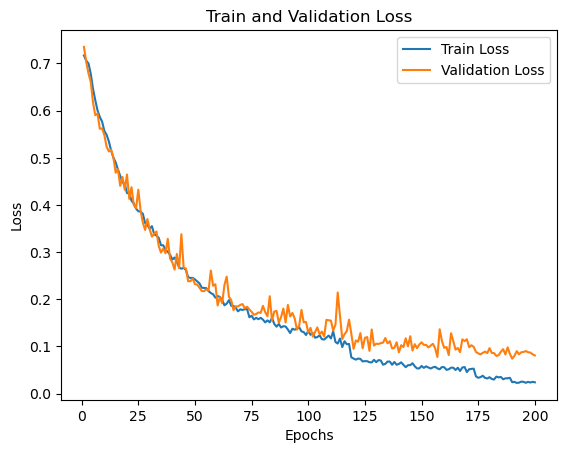

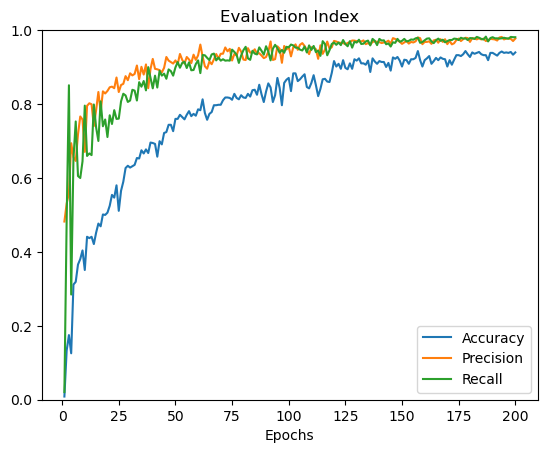

In [9]:
csv_path = 'data/data1.csv'  # 数据集的CSV文件路径
batch_size = 32 # 每个batch的样本数量
num_epochs = 200  # 总的训练周期数
input_dim = 1# 输入特征的维度，需根据实际数据进行调整
window_size = 100
stride = 100
hidden_dim = 256
nlayer=1
num_classes = 3  # 多标签分类的标签数量


# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 加载数据，得到训练集和测试集的DataLoader
train_loader,val_loader, test_loader = load_data(csv_path, batch_size=batch_size, test_size=0.1, val_size=0.111111, device=device)

# if test_in==0.001:
#     # 加载测试数据
#     _, test_loader = load_data(test_csv_path, batch_size=batch_size, test_size=0.99, device=device)
#     print('读取外部csv文件作为测试集')

# 定义Transformer编码器模型
model = TransformerMultiLabel(input_dim=input_dim, embedding_dim=hidden_dim, window_size=window_size, stride=stride, 
                              num_heads=2, num_classes=num_classes,nlayer=nlayer, dropout=0.2).to(device)
# 特征维度(样本大小)，每个特征的维度，transformer维度
# model.load_state_dict(torch.load('./best_model/best_model-97.pth'))

# 定义损失函数：二元交叉熵
criterion = nn.BCELoss().to(device)
# criterion = FocalLoss(alpha=2, gamma=2)

# 定义优化器：Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 学习率调度器，当验证损失不再下降时，降低学习率
# mode： 'min’模式检测metric是否不再减小，'max’模式检测metric是否不再增大；
# factor：触发条件后lr*=factor；
# patience：当指标连续patience次没有改进时，降低学习率；
# verbose：触发条件后print；
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=15, verbose=True)

# 训练模型，记录损失
train_losses, val_losses,Accuracy, Precision, Recall, Nar= train_model(model,scheduler, train_loader, val_loader, criterion, optimizer, 
                                                                  num_epochs=num_epochs, lambda_mi =0.02, device=device)

# 评估模型并绘制损失曲线z
All_labels, All_preds = evaluate_model(model, val_loader, criterion, train_losses, val_losses,
               Accuracy, Precision, Recall, lambda_mi = 0.02,device=device)




In [ ]:
train_losses = pd.DataFrame(train_losses)
val_losses = pd.DataFrame(val_losses)
Accuracy = pd.DataFrame(Accuracy)
Precision = pd.DataFrame(Precision)
Recall = pd.DataFrame(Recall)
temp = pd.concat((train_losses, val_losses,Accuracy, Precision, Recall), axis=1)
temp.columns = ['train_losses', 'val_losses', 'Accuracy', 'Precision', 'Recall']
temp.to_csv('FTIformer.csv', index=False)
temp